                            OLS Regression Results                            
Dep. Variable:                   e_cs   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     2.456
Date:                Tue, 30 Apr 2024   Prob (F-statistic):             0.0611
Time:                        13:56:43   Log-Likelihood:                -4454.2
No. Observations:               11792   AIC:                             8916.
Df Residuals:                   11788   BIC:                             8946.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

ConversionError: Failed to convert value(s) to axis units: '2018-08-01'

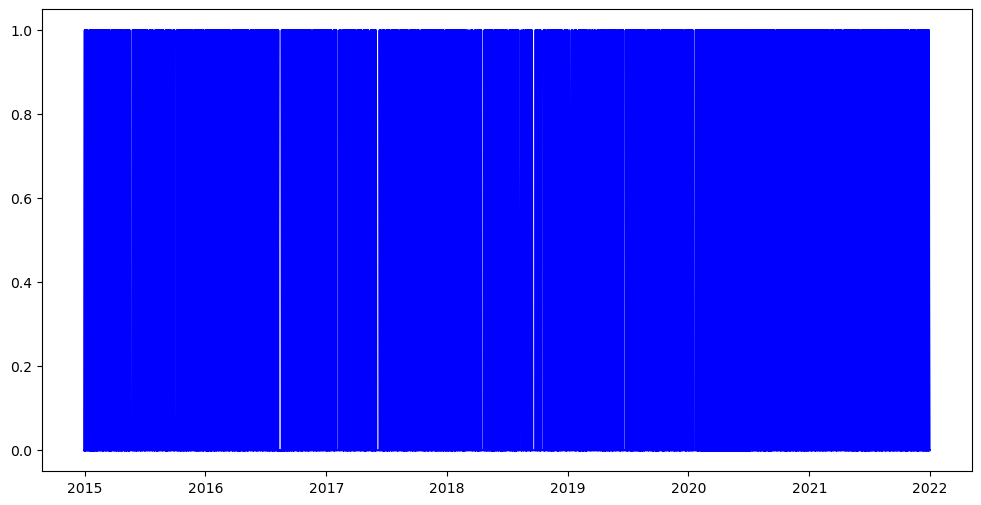

In [4]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from statsmodels.formula.api import ols
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt

# データの読み込み
data = pd.read_excel('D:/from_689/adachi_concat.xlsx', parse_dates=['labor_date'])

# 全期間のデータを選択
data['time'] = (data['labor_date'] - data['labor_date'].min()).dt.days  # 研究開始からの日数
data['post_intervention'] = (data['labor_date'] >= '2018-08-01').astype(int)  # 介入後は1, それ以前は0
data['time_after_intervention'] = np.where(data['post_intervention'] == 1, data['time'] - data[data['post_intervention'] == 1]['time'].min(), 0)

# 分割時系列解析のモデル
model = ols('e_cs ~ time + post_intervention + time_after_intervention', data=data).fit()

# 結果の出力
print(model.summary())

# 傾向スコアを用いたマッチング（任意で追加）
# ここでは単純な時系列解析のみを示しますが、傾向スコアマッチングを行いたい場合は別途設定が必要です

# 時系列データのプロット
plt.figure(figsize=(12, 6))
plt.plot(data['labor_date'], data['e_cs'], label='e_cs', color='blue')
plt.axvline('2018-08-01', color='red', linestyle='--', label='Intervention')
plt.title('e_cs Over Time with Intervention')
plt.xlabel('Date')
plt.ylabel('e_cs')
plt.legend()
plt.show()


                            OLS Regression Results                            
Dep. Variable:                   e_cs   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.441
Date:                Tue, 30 Apr 2024   Prob (F-statistic):              0.237
Time:                        14:09:07   Log-Likelihood:                -2254.2
No. Observations:                5850   AIC:                             4514.
Df Residuals:                    5847   BIC:                             4534.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

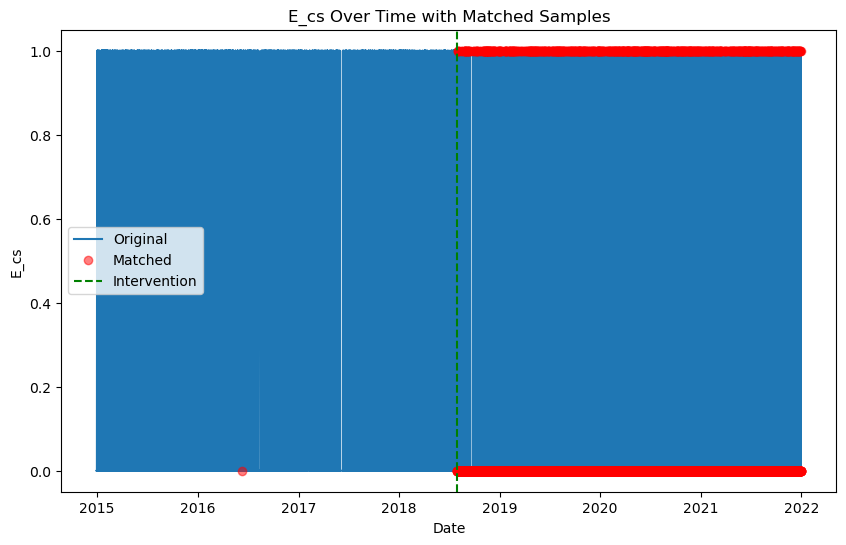

In [10]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import pairwise_distances
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt

# データの読み込み
data = pd.read_excel('D:/from_689/adachi_concat.xlsx', parse_dates=['labor_date'])

# 介入日の設定
intervention_date = pd.Timestamp('2018-08-01')

# 介入の有無を示すダミー変数と、介入前後の時間変数を作成
data['post_intervention'] = (data['labor_date'] >= intervention_date).astype(int)
data['time'] = (data['labor_date'] - data['labor_date'].min()).dt.days
data['time_after_intervention'] = np.where(data['post_intervention'] == 1, 
                                           data['time'] - (intervention_date - data['labor_date'].min()).days, 0)

# 傾向スコアの計算用の変数を定義
predictors = ['age', 'height', 'weight', 'weeks']  # 調整変数を追加
X = data[predictors + ['post_intervention']]
y = data['post_intervention']

# ロジスティック回帰モデルで傾向スコアを計算
model = LogisticRegression()
model.fit(X, y)
data['propensity_score'] = model.predict_proba(X)[:, 1]

# マッチング
treated = data[data['post_intervention'] == 1]
control = data[data['post_intervention'] == 0]
distances = pairwise_distances(treated[['propensity_score']], control[['propensity_score']], metric='euclidean')
closest = np.argmin(distances, axis=1)
matched_control = control.iloc[closest]

# マッチングされたデータセットの生成
matched_data = pd.concat([treated, matched_control]).drop_duplicates()

# 分割時系列解析モデルの定義と実行
formula = 'e_cs ~ time + post_intervention + time_after_intervention'
model_itsa = ols(formula, data=matched_data).fit()

# 結果の出力
print(model_itsa.summary())

# 傾向スコアマッチング後のプロット
plt.figure(figsize=(10, 6))
plt.plot(data['labor_date'], data['e_cs'], label='Original')
plt.plot(matched_data['labor_date'], matched_data['e_cs'], 'ro', label='Matched', alpha=0.5)
plt.axvline(intervention_date, color='green', linestyle='--', label='Intervention')
plt.title('E_cs Over Time with Matched Samples')
plt.xlabel('Date')
plt.ylabel('E_cs')
plt.legend()
plt.show()


C:\Users\bougt\AppData\Local\Temp\ipykernel_14536\4013144801.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.fill_between(monthly_data['month'], prediction - 1.96 * results.bse[0], prediction + 1.96 * results.bse[0], color='red', alpha=0.3)


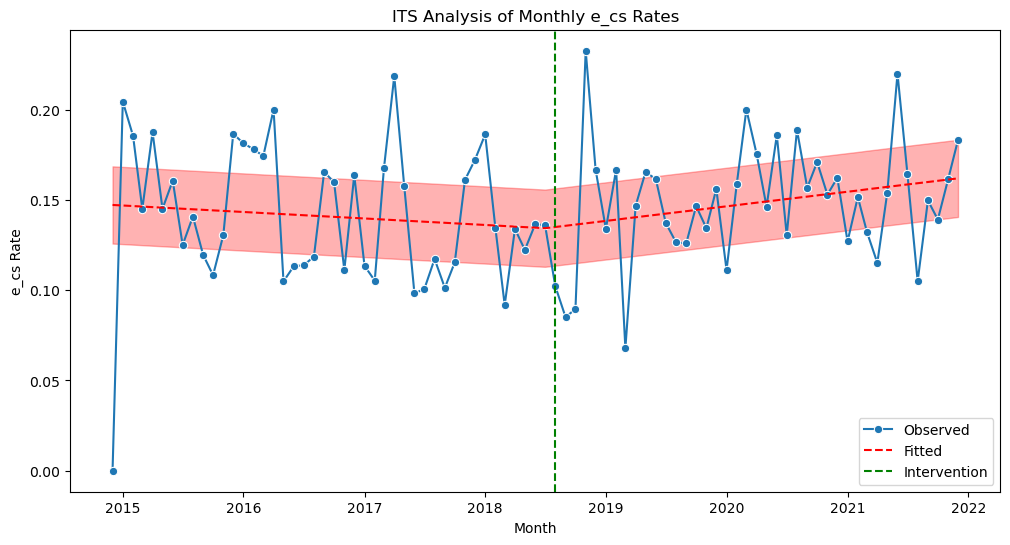

In [11]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

# データの読み込み
data = pd.read_excel('D:/from_689/adachi_concat.xlsx', parse_dates=['labor_date'])

# 月単位でデータを集約
data['month'] = data['labor_date'].dt.to_period('M')
monthly_data = data.groupby('month')['e_cs'].mean().reset_index()
monthly_data['month'] = monthly_data['month'].dt.to_timestamp()

# 介入の有無を示す変数を追加
intervention_date = pd.Timestamp('2018-08-01')
monthly_data['post_intervention'] = (monthly_data['month'] >= intervention_date).astype(int)
monthly_data['time'] = np.arange(len(monthly_data))

# 介入前後の時間変数を追加
monthly_data['time_after_intervention'] = monthly_data['time'] - monthly_data[monthly_data['post_intervention'] == 1]['time'].min()
monthly_data['time_after_intervention'] *= monthly_data['post_intervention']  # 介入後のみカウント

# 回帰モデルの構築
model = sm.OLS(monthly_data['e_cs'], sm.add_constant(monthly_data[['time', 'post_intervention', 'time_after_intervention']]))
results = model.fit()

# 結果のプロット
plt.figure(figsize=(12, 6))
sns.lineplot(x='month', y='e_cs', data=monthly_data, marker='o', label='Observed')
prediction = results.predict(sm.add_constant(monthly_data[['time', 'post_intervention', 'time_after_intervention']]))
plt.plot(monthly_data['month'], prediction, color='red', linestyle='--', label='Fitted')
plt.axvline(intervention_date, color='green', linestyle='--', label='Intervention')
plt.fill_between(monthly_data['month'], prediction - 1.96 * results.bse[0], prediction + 1.96 * results.bse[0], color='red', alpha=0.3)
plt.title('ITS Analysis of Monthly e_cs Rates')
plt.xlabel('Month')
plt.ylabel('e_cs Rate')
plt.legend()
plt.show()


C:\Users\bougt\AppData\Local\Temp\ipykernel_14536\2826955268.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['month'] = filtered_data['labor_date'].dt.to_period('M')
C:\Users\bougt\AppData\Local\Temp\ipykernel_14536\2826955268.py:40: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.fill_between(monthly_data['month'], prediction - 1.96 * results.bse[0], prediction + 1.96 * results.bse[0], color='red', alpha=0.3)


                            OLS Regression Results                            
Dep. Variable:                   e_cs   R-squared:                       0.050
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     1.410
Date:                Tue, 30 Apr 2024   Prob (F-statistic):              0.246
Time:                        14:18:40   Log-Likelihood:                 54.205
No. Observations:                  84   AIC:                            -100.4
Df Residuals:                      80   BIC:                            -90.69
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

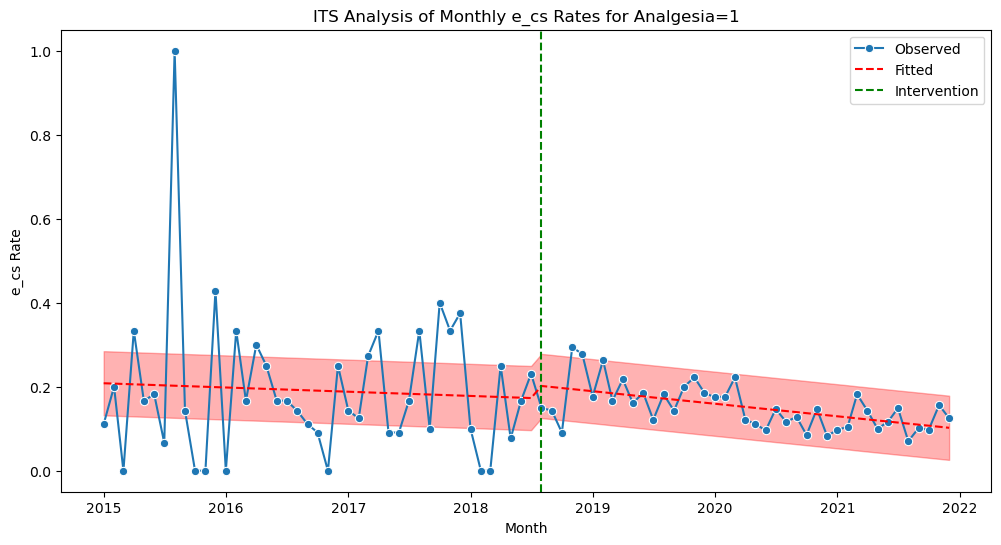

In [15]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

# データの読み込み
data = pd.read_excel('D:/from_689/adachi_concat.xlsx', parse_dates=['labor_date'])

# analgesia=1 のデータに絞る
filtered_data = data[data['analgesia'] == 1]

# 月単位でデータを集約
filtered_data['month'] = filtered_data['labor_date'].dt.to_period('M')
monthly_data = filtered_data.groupby('month')['e_cs'].mean().reset_index()
monthly_data['month'] = monthly_data['month'].dt.to_timestamp()

# 介入の有無を示す変数を追加
intervention_date = pd.Timestamp('2018-08-01')
monthly_data['post_intervention'] = (monthly_data['month'] >= intervention_date).astype(int)
monthly_data['time'] = np.arange(len(monthly_data))

# 介入前後の時間変数を追加
monthly_data['time_after_intervention'] = monthly_data['time'] - monthly_data[monthly_data['post_intervention'] == 1]['time'].min()
monthly_data['time_after_intervention'] *= monthly_data['post_intervention']  # 介入後のみカウント

# 回帰モデルの構築
model = sm.OLS(monthly_data['e_cs'], sm.add_constant(monthly_data[['time', 'post_intervention', 'time_after_intervention']]))
results = model.fit()

# 結果の出力
print(results.summary())

# 結果のプロット
plt.figure(figsize=(12, 6))
sns.lineplot(x='month', y='e_cs', data=monthly_data, marker='o', label='Observed')
prediction = results.predict(sm.add_constant(monthly_data[['time', 'post_intervention', 'time_after_intervention']]))
plt.plot(monthly_data['month'], prediction, color='red', linestyle='--', label='Fitted')
plt.axvline(intervention_date, color='green', linestyle='--', label='Intervention')
plt.fill_between(monthly_data['month'], prediction - 1.96 * results.bse[0], prediction + 1.96 * results.bse[0], color='red', alpha=0.3)
plt.title('ITS Analysis of Monthly e_cs Rates for Analgesia=1')
plt.xlabel('Month')
plt.ylabel('e_cs Rate')
plt.legend()
plt.show()


# ↑analgesia=1の分割時系列解析

C:\Users\bougt\AppData\Local\Temp\ipykernel_14536\1153007908.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['month'] = filtered_data['labor_date'].dt.to_period('M')
C:\Users\bougt\AppData\Local\Temp\ipykernel_14536\1153007908.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.fill_between(monthly_data['month'], prediction - 1.96 * results.bse[0], prediction + 1.96 * results.bse[0], color='red', alpha=0.3)


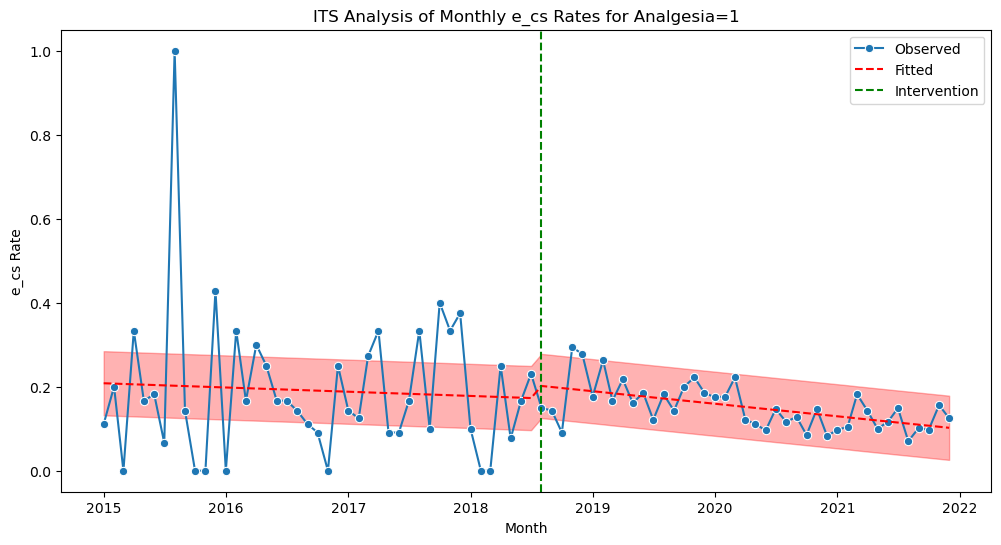

In [13]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

# データの読み込み
data = pd.read_excel('D:/from_689/adachi_concat.xlsx', parse_dates=['labor_date'])

# analgesia=1 のデータに絞る
filtered_data = data[data['analgesia'] == 1]

# 月単位でデータを集約
filtered_data['month'] = filtered_data['labor_date'].dt.to_period('M')
monthly_data = filtered_data.groupby('month')['e_cs'].mean().reset_index()
monthly_data['month'] = monthly_data['month'].dt.to_timestamp()

# 介入の有無を示す変数を追加
intervention_date = pd.Timestamp('2018-08-01')
monthly_data['post_intervention'] = (monthly_data['month'] >= intervention_date).astype(int)
monthly_data['time'] = np.arange(len(monthly_data))

# 介入前後の時間変数を追加
monthly_data['time_after_intervention'] = monthly_data['time'] - monthly_data[monthly_data['post_intervention'] == 1]['time'].min()
monthly_data['time_after_intervention'] *= monthly_data['post_intervention']  # 介入後のみカウント

# 回帰モデルの構築
model = sm.OLS(monthly_data['e_cs'], sm.add_constant(monthly_data[['time', 'post_intervention', 'time_after_intervention']]))
results = model.fit()

# 結果のプロット
plt.figure(figsize=(12, 6))
sns.lineplot(x='month', y='e_cs', data=monthly_data, marker='o', label='Observed')
prediction = results.predict(sm.add_constant(monthly_data[['time', 'post_intervention', 'time_after_intervention']]))
plt.plot(monthly_data['month'], prediction, color='red', linestyle='--', label='Fitted')
plt.axvline(intervention_date, color='green', linestyle='--', label='Intervention')
plt.fill_between(monthly_data['month'], prediction - 1.96 * results.bse[0], prediction + 1.96 * results.bse[0], color='red', alpha=0.3)
plt.title('ITS Analysis of Monthly e_cs Rates for Analgesia=1')
plt.xlabel('Month')
plt.ylabel('e_cs Rate')
plt.legend()
plt.show()


C:\Users\bougt\AppData\Local\Temp\ipykernel_14536\204092338.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['month'] = filtered_data['labor_date'].dt.to_period('M')
C:\Users\bougt\AppData\Local\Temp\ipykernel_14536\204092338.py:40: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.fill_between(monthly_data['month'], prediction - 1.96 * results.bse[0], prediction + 1.96 * results.bse[0], color='red', alpha=0.3)


                            OLS Regression Results                            
Dep. Variable:                   e_cs   R-squared:                       0.131
Model:                            OLS   Adj. R-squared:                  0.099
Method:                 Least Squares   F-statistic:                     4.067
Date:                Tue, 30 Apr 2024   Prob (F-statistic):            0.00960
Time:                        14:20:27   Log-Likelihood:                 154.18
No. Observations:                  85   AIC:                            -300.4
Df Residuals:                      81   BIC:                            -290.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

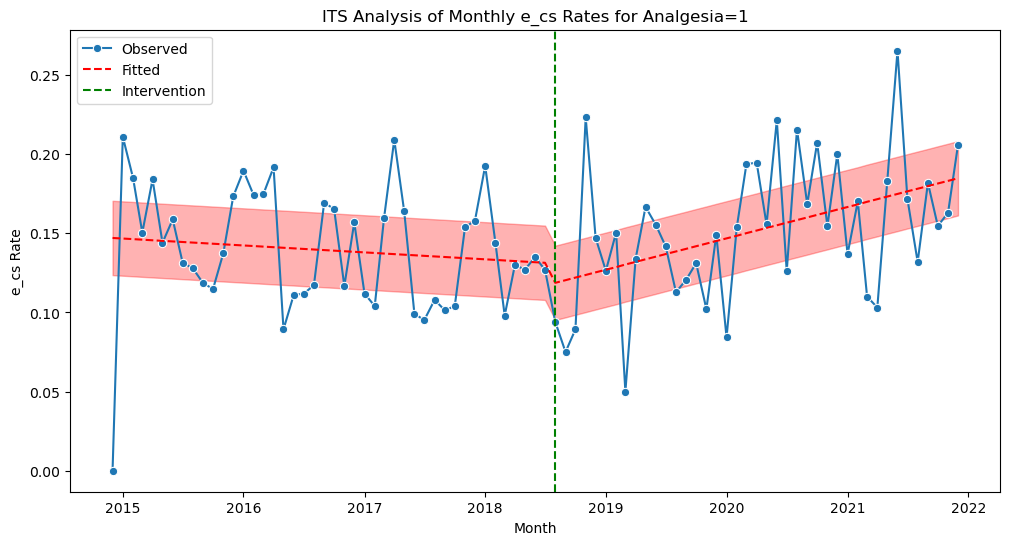

In [16]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

# データの読み込み
data = pd.read_excel('D:/from_689/adachi_concat.xlsx', parse_dates=['labor_date'])

# analgesia=1 のデータに絞る
filtered_data = data[data['analgesia'] == 0]

# 月単位でデータを集約
filtered_data['month'] = filtered_data['labor_date'].dt.to_period('M')
monthly_data = filtered_data.groupby('month')['e_cs'].mean().reset_index()
monthly_data['month'] = monthly_data['month'].dt.to_timestamp()

# 介入の有無を示す変数を追加
intervention_date = pd.Timestamp('2018-08-01')
monthly_data['post_intervention'] = (monthly_data['month'] >= intervention_date).astype(int)
monthly_data['time'] = np.arange(len(monthly_data))

# 介入前後の時間変数を追加
monthly_data['time_after_intervention'] = monthly_data['time'] - monthly_data[monthly_data['post_intervention'] == 1]['time'].min()
monthly_data['time_after_intervention'] *= monthly_data['post_intervention']  # 介入後のみカウント

# 回帰モデルの構築
model = sm.OLS(monthly_data['e_cs'], sm.add_constant(monthly_data[['time', 'post_intervention', 'time_after_intervention']]))
results = model.fit()

# 結果の出力
print(results.summary())

# 結果のプロット
plt.figure(figsize=(12, 6))
sns.lineplot(x='month', y='e_cs', data=monthly_data, marker='o', label='Observed')
prediction = results.predict(sm.add_constant(monthly_data[['time', 'post_intervention', 'time_after_intervention']]))
plt.plot(monthly_data['month'], prediction, color='red', linestyle='--', label='Fitted')
plt.axvline(intervention_date, color='green', linestyle='--', label='Intervention')
plt.fill_between(monthly_data['month'], prediction - 1.96 * results.bse[0], prediction + 1.96 * results.bse[0], color='red', alpha=0.3)
plt.title('ITS Analysis of Monthly e_cs Rates for Analgesia=1')
plt.xlabel('Month')
plt.ylabel('e_cs Rate')
plt.legend()
plt.show()


In [ ]:
# ↑analgesia=0の分割時系列解析

post_intervention の係数が正の場合、介入によって e_cs の割合が増加したことを示し、負の場合は割合が減少したことを示します。この係数の p 値が0.05以下であれば、介入による即時の変化が統計的に有意であると言えます。
time_after_intervention の係数が正の場合、介入後の時間が経つにつれて e_cs の割合が増加するトレンドがあることを示し、負の場合は減少するトレンドがあることを示します。この係数の p 値が0.05以下であれば、介入による時間経過に伴うトレンドの変化が統計的に有意であると言えます。
つまりこのデータにおいてはanalgesia=0の場合に、介入後時間経過とともにe_csが増加するトレンドがあるといえる

C:\Users\bougt\AppData\Local\Temp\ipykernel_14536\3019776602.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['month'] = df['labor_date'].dt.to_period('M')
C:\Users\bougt\AppData\Local\Temp\ipykernel_14536\3019776602.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['month'] = df['labor_date'].dt.to_period('M')


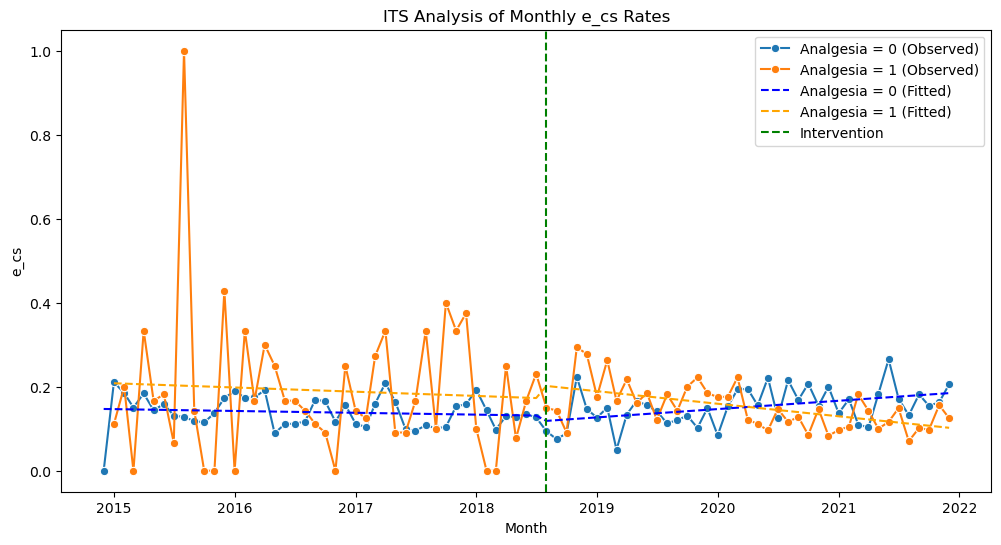

AttributeError: 'NoneType' object has no attribute 'ylabel'

In [54]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
data = pd.read_excel('D:/from_689/adachi_concat.xlsx', parse_dates=['labor_date'])

# Function to prepare the data
def prepare_data(data, analgesia_value):
    # Filter data for the analgesia value
    df = data[data['analgesia'] == analgesia_value]
    # Aggregate data by month
    df['month'] = df['labor_date'].dt.to_period('M')
    monthly_data = df.groupby('month')['e_cs'].mean().reset_index()
    monthly_data['month'] = monthly_data['month'].dt.to_timestamp()
    
    # Create intervention indicator and time variables
    intervention_date = pd.Timestamp('2018-08-01')
    monthly_data['post_intervention'] = (monthly_data['month'] >= intervention_date).astype(int)
    monthly_data['time'] = np.arange(len(monthly_data))
    monthly_data['time_after_intervention'] = np.where(monthly_data['post_intervention'] == 1, 
                                                       monthly_data['time'] - monthly_data.loc[monthly_data['post_intervention'] == 1, 'time'].min(), 
                                                       0)
    
    # Fit the regression model
    model = sm.OLS(monthly_data['e_cs'], sm.add_constant(monthly_data[['time', 'post_intervention', 'time_after_intervention']]))
    results = model.fit()
    monthly_data['fitted'] = results.predict(sm.add_constant(monthly_data[['time', 'post_intervention', 'time_after_intervention']]))
    
    return monthly_data, results

# Prepare the data for analgesia = 0 and analgesia = 1
monthly_data_0, results_0 = prepare_data(data, 0)
monthly_data_1, results_1 = prepare_data(data, 1)

# Plot the results
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_data_0, x='month', y='e_cs', marker='o', label='Analgesia = 0 (Observed)')
sns.lineplot(data=monthly_data_1, x='month', y='e_cs', marker='o', label='Analgesia = 1 (Observed)')
plt.plot(monthly_data_0['month'], monthly_data_0['fitted'], color='blue', linestyle='--', label='Analgesia = 0 (Fitted)')
plt.plot(monthly_data_1['month'], monthly_data_1['fitted'], color='orange', linestyle='--', label='Analgesia = 1 (Fitted)')
plt.axvline(intervention_date, color='green', linestyle='--', label='Intervention')
plt.title('ITS Analysis of Monthly e_cs Rates')
plt.legend()
plt.xlabel('Month')
plt.ylabel('e_cs')
plt.show().ylabel('e_cs Rate')
plt.legend()
plt.show()



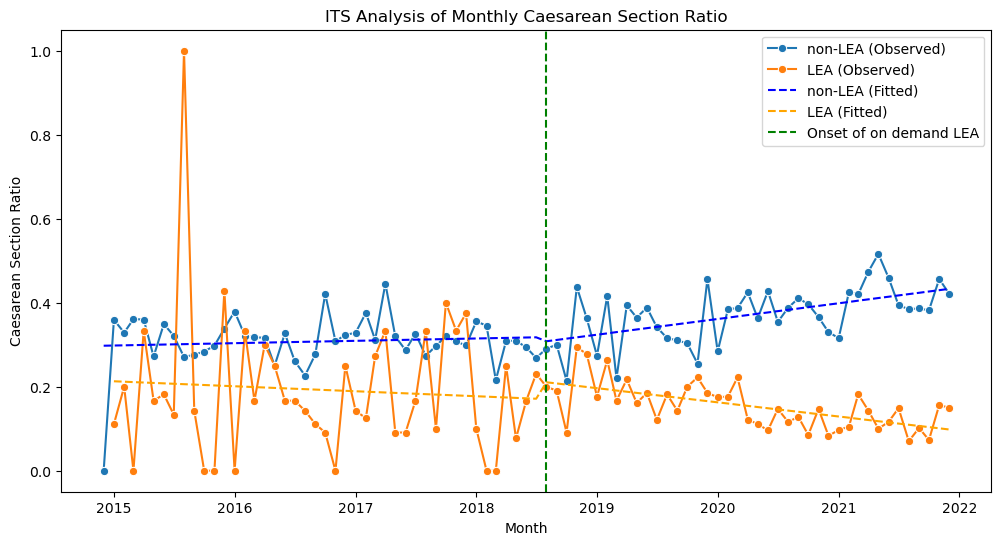

In [52]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

# データの読み込み
data = pd.read_excel('D:/from_689/adachi_concat.xlsx', parse_dates=['labor_date'])

data['bmi'] = 10000 * data['weight'] / (data['height'] * data['height'])
data['c/s'] = data['mode_section'].astype(int)

# Function to prepare the data
def prepare_data(data, analgesia_value):
    # Filter data for the analgesia value
    df = data[data['analgesia'] == analgesia_value].copy()
    # Aggregate data by month
    df.loc[:, 'month'] = df['labor_date'].dt.to_period('M')
    monthly_data = df.groupby('month')['c/s'].mean().reset_index()
    monthly_data['month'] = monthly_data['month'].dt.to_timestamp()
    
    # Create intervention indicator and time variables
    intervention_date = pd.Timestamp('2018-08-01')
    monthly_data['post_intervention'] = (monthly_data['month'] >= intervention_date).astype(int)
    monthly_data['time'] = np.arange(len(monthly_data))
    monthly_data['time_after_intervention'] = np.where(monthly_data['post_intervention'] == 1, 
                                                       monthly_data['time'] - monthly_data.loc[monthly_data['post_intervention'] == 1, 'time'].min(), 
                                                       0)
    
    # Fit the regression model
    model = sm.OLS(monthly_data['c/s'], sm.add_constant(monthly_data[['time', 'post_intervention', 'time_after_intervention']]))
    results = model.fit()
    monthly_data['fitted'] = results.predict(sm.add_constant(monthly_data[['time', 'post_intervention', 'time_after_intervention']]))
    
    return monthly_data, results

# Prepare the data for analgesia = 0 and analgesia = 1
monthly_data_0, results_0 = prepare_data(data, 0)
monthly_data_1, results_1 = prepare_data(data, 1)

# Plot the results
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_data_0, x='month', y='c/s', marker='o', label='non-LEA (Observed)')
sns.lineplot(data=monthly_data_1, x='month', y='c/s', marker='o', label='LEA (Observed)')
plt.plot(monthly_data_0['month'], monthly_data_0['fitted'], color='blue', linestyle='--', label='non-LEA (Fitted)')
plt.plot(monthly_data_1['month'], monthly_data_1['fitted'], color='orange', linestyle='--', label='LEA (Fitted)')
plt.axvline(intervention_date, color='green', linestyle='--', label='Onset of on demand LEA')
plt.title('ITS Analysis of Monthly Caesarean Section Ratio')
plt.xlabel('Month')
plt.ylabel('Caesarean Section Ratio')
plt.legend()
plt.show()


                            OLS Regression Results                            
Dep. Variable:                    c/s   R-squared:                       0.312
Model:                            OLS   Adj. R-squared:                  0.287
Method:                 Least Squares   F-statistic:                     12.27
Date:                Fri, 03 May 2024   Prob (F-statistic):           1.07e-06
Time:                        09:03:52   Log-Likelihood:                 117.76
No. Observations:                  85   AIC:                            -227.5
Df Residuals:                      81   BIC:                            -217.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

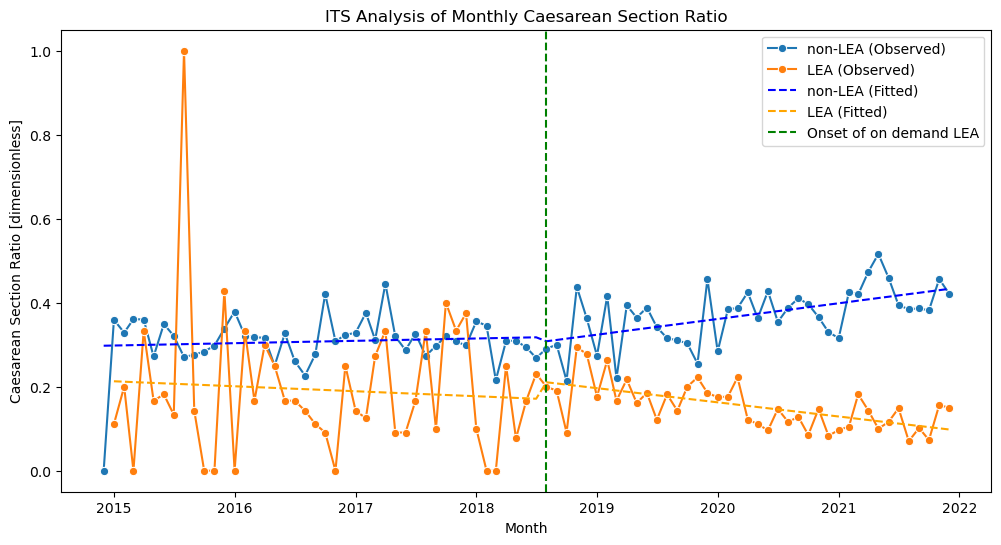

In [56]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

# データの読み込み
data = pd.read_excel('D:/from_689/adachi_concat.xlsx', parse_dates=['labor_date'])

data['bmi'] = 10000 * data['weight'] / (data['height'] * data['height'])
data['c/s'] = data['mode_section'].astype(int)

# Function to prepare the data
def prepare_data(data, analgesia_value):
    df = data[data['analgesia'] == analgesia_value].copy()
    df.loc[:, 'month'] = df['labor_date'].dt.to_period('M')
    monthly_data = df.groupby('month')['c/s'].mean().reset_index()
    monthly_data['month'] = monthly_data['month'].dt.to_timestamp()
    
    intervention_date = pd.Timestamp('2018-08-01')
    monthly_data['post_intervention'] = (monthly_data['month'] >= intervention_date).astype(int)
    monthly_data['time'] = np.arange(len(monthly_data))
    monthly_data['time_after_intervention'] = np.where(monthly_data['post_intervention'] == 1, 
                                                       monthly_data['time'] - monthly_data.loc[monthly_data['post_intervention'] == 1, 'time'].min(), 
                                                       0)
    
    model = sm.OLS(monthly_data['c/s'], sm.add_constant(monthly_data[['time', 'post_intervention', 'time_after_intervention']]))
    results = model.fit()
    monthly_data['fitted'] = results.predict(sm.add_constant(monthly_data[['time', 'post_intervention', 'time_after_intervention']]))

    # Print the summary of the regression model
    print(results.summary())

    return monthly_data, results

# Prepare the data for analgesia = 0 and analgesia = 1
monthly_data_0, results_0 = prepare_data(data, 0)
monthly_data_1, results_1 = prepare_data(data, 1)

# Plot the results
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_data_0, x='month', y='c/s', marker='o', label='non-LEA (Observed)')
sns.lineplot(data=monthly_data_1, x='month', y='c/s', marker='o', label='LEA (Observed)')
plt.plot(monthly_data_0['month'], monthly_data_0['fitted'], color='blue', linestyle='--', label='non-LEA (Fitted)')
plt.plot(monthly_data_1['month'], monthly_data_1['fitted'], color='orange', linestyle='--', label='LEA (Fitted)')
plt.axvline(intervention_date, color='green', linestyle='--', label='Onset of on demand LEA')
plt.title('ITS Analysis of Monthly Caesarean Section Ratio')
plt.xlabel('Month')
plt.ylabel('Caesarean Section Ratio [dimensionless]')
plt.legend()
plt.show()


                            OLS Regression Results                            
Dep. Variable:                   e_cs   R-squared:                       0.131
Model:                            OLS   Adj. R-squared:                  0.099
Method:                 Least Squares   F-statistic:                     4.067
Date:                Fri, 03 May 2024   Prob (F-statistic):            0.00960
Time:                        09:04:47   Log-Likelihood:                 154.18
No. Observations:                  85   AIC:                            -300.4
Df Residuals:                      81   BIC:                            -290.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

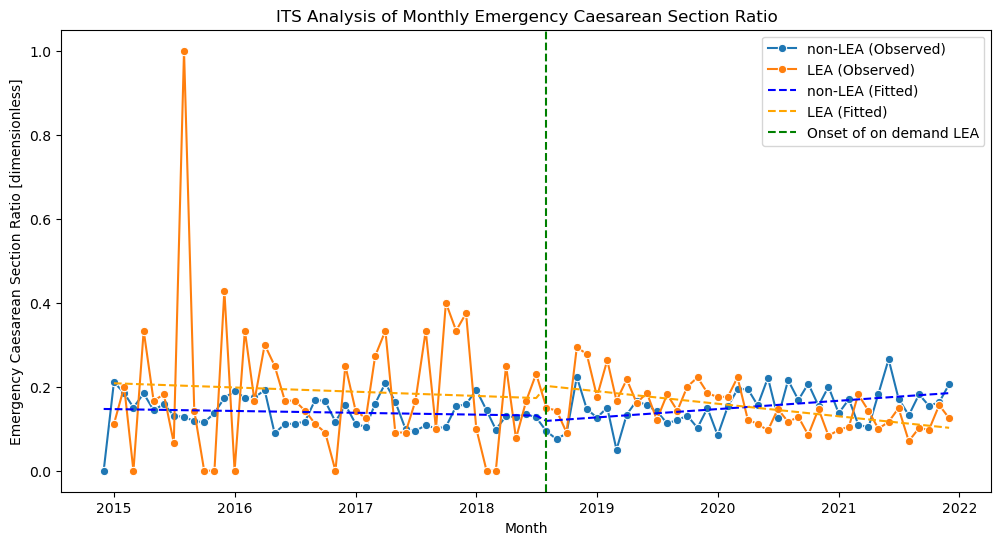

In [57]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

# データの読み込み
data = pd.read_excel('D:/from_689/adachi_concat.xlsx', parse_dates=['labor_date'])

data['bmi'] = 10000 * data['weight'] / (data['height'] * data['height'])
data['c/s'] = data['mode_section'].astype(int)

# Function to prepare the data
def prepare_data(data, analgesia_value):
    df = data[data['analgesia'] == analgesia_value].copy()
    df.loc[:, 'month'] = df['labor_date'].dt.to_period('M')
    monthly_data = df.groupby('month')['e_cs'].mean().reset_index()
    monthly_data['month'] = monthly_data['month'].dt.to_timestamp()
    
    intervention_date = pd.Timestamp('2018-08-01')
    monthly_data['post_intervention'] = (monthly_data['month'] >= intervention_date).astype(int)
    monthly_data['time'] = np.arange(len(monthly_data))
    monthly_data['time_after_intervention'] = np.where(monthly_data['post_intervention'] == 1, 
                                                       monthly_data['time'] - monthly_data.loc[monthly_data['post_intervention'] == 1, 'time'].min(), 
                                                       0)
    
    model = sm.OLS(monthly_data['e_cs'], sm.add_constant(monthly_data[['time', 'post_intervention', 'time_after_intervention']]))
    results = model.fit()
    monthly_data['fitted'] = results.predict(sm.add_constant(monthly_data[['time', 'post_intervention', 'time_after_intervention']]))

    # Print the summary of the regression model
    print(results.summary())

    return monthly_data, results

# Prepare the data for analgesia = 0 and analgesia = 1
monthly_data_0, results_0 = prepare_data(data, 0)
monthly_data_1, results_1 = prepare_data(data, 1)

# Plot the results
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_data_0, x='month', y='e_cs', marker='o', label='non-LEA (Observed)')
sns.lineplot(data=monthly_data_1, x='month', y='e_cs', marker='o', label='LEA (Observed)')
plt.plot(monthly_data_0['month'], monthly_data_0['fitted'], color='blue', linestyle='--', label='non-LEA (Fitted)')
plt.plot(monthly_data_1['month'], monthly_data_1['fitted'], color='orange', linestyle='--', label='LEA (Fitted)')
plt.axvline(intervention_date, color='green', linestyle='--', label='Onset of on demand LEA')
plt.title('ITS Analysis of Monthly Emergency Caesarean Section Ratio')
plt.xlabel('Month')
plt.ylabel('Emergency Caesarean Section Ratio [dimensionless]')
plt.legend()
plt.show()


In [ ]:
前後比較でしてみよう